In [1]:
!pip install pandas_ml
!pip install scikit-learn==0.21
!pip install pandas==0.24.2

In [2]:
import keras
import cv2
import keras
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import glob as glb
import pandas as pd
import tensorflow as tf
from __future__ import print_function
from sklearn.metrics import classification_report
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from keras.utils import to_categorical
from pandas_ml import ConfusionMatrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adadelta
from keras import optimizers
from google.colab  import files, drive

drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Mounted at /content/drive


In [3]:
def getCSV(resultat, path_output):
  """
  input : dict(result), str(path to csv)
  output : obj(df)
  """
  df = pd.DataFrame.from_dict(resultat, orient="index")
  # print(df)
  return df.to_csv(path_output, sep="\t", encoding="utf8")

## Ecriture des résultats

### Utilisation d'un dictionnaire avant de le transformer en dataframe

In [4]:
def getScoreLocuteur(report):
  """
  input : str(classification report)
  output : dict(scores)
  """
  lignes = report.split("\n")
  score = {}
  for n in range(1, len(lignes)):
    # print(lignes[n])
    if lignes[n] != "":
      lignes[n] = lignes[n].strip()
      if 'avg' in lignes[n]: lignes[n] = re.sub(" avg", "_avg",lignes[n])
      data = lignes[n].split()
      if data[0] != "accuracy":
        # print(data)
        score["precision_"+data[0]] = data[1]
        score["recall_"+data[0]] = data[2]
        score["f1_score_"+data[0]] = data[3]
        score["support_"+data[0]] = data[4]
      else:
        score["f1_score_"+data[0]] = data[1]
        score["support_"+data[0]] = data[2]

  return score

In [5]:
def getScoreContexte(report, fileName):
  """
  input : str(classification report)
  output : dict(scores)
  """
  lignes = report.split("\n")
  score = {}
  score["son"] = fileName.split('_')[7]
  score["contexte_gauche"] = fileName.split('_')[-4]
  score["contexte_droit"] = fileName.split('_')[-3]
  score["contextes"] = fileName.split('_')[-4] + "_" + fileName.split('_')[-3]
  for n in range(1, len(lignes)):
    # print(lignes[n])
    if lignes[n] != "":
      lignes[n] = lignes[n].strip()
      if 'avg' in lignes[n]: lignes[n] = re.sub(" avg", "_avg",lignes[n])
      data = lignes[n].split()
      if data[0] != "accuracy":
        # print(data)
        score["precision_"+data[0]] = data[1]
        score["recall_"+data[0]] = data[2]
        score["f1_score_"+data[0]] = data[3]
        score["support_"+data[0]] = data[4]
      else:
        score["f1_score_"+data[0]] = data[1]
        score["support_"+data[0]] = data[2]
    

  return score

### Initiation d'une liste pour sauvegarder les identifiants des locuteurs

In [6]:
def getListLocuteur(path_to_files):
  """
  input : str(path to files)
  output : list(list of speakers)
  """
  locs = list()
  for path in glb.glob(path_to_files):
    loc_file = "_".join(path.split('/')[-1].split('_')[0:6])
    if loc_file not in locs:
      locs.append(loc_file)
  return locs

In [7]:
def getListSegment(path_to_files):
  """
  input : str(path to files)
  output : list(list of segments)
  """
  segments = list()
  for path in glb.glob(path_to_files):
    segment = path.split('/')[-1].split('_')[6]
    if segment not in segments:
      segments.append(segment)
  return segments

### Récupérations et transformations des données : les données à prédire

In [8]:
def getTestSetLocuteur(locuteur, path_input, img_rows=28, img_cols=28, num_classes=2):
  """
  input : str(id_locuteur), str(path to test files), int(image_rows), int(image_cols), int(number-classes)
  output : list(images), list(label)
  """
  x_test_loc = []
  y_test_loc = []
  fileNames_loc = []
  for path in glb.glob(path_input):
  #print(path)
    fileName = path.split('/')[-1]
  #print(fileName)
  #print(fileName.split('_'))
    if locuteur in fileName: 
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_loc.append(x)
      y_test_loc.append(y)
      fileNames_loc.append(fileName)

  #print(len(x_test_loc))
  x_test_loc = np.array(x_test_loc)
  x_test_loc = x_test_loc.reshape(-1, x_test_loc.shape[1],x_test_loc.shape[2],1)
  x_test_loc = x_test_loc.astype('float32')
  x_test_loc /= 255. 

  y_test_loc = np.array(y_test_loc)
  y_test_loc = to_categorical(y_test_loc, num_classes, dtype='float32')
  return x_test_loc, y_test_loc, fileNames_loc

In [9]:
def getTestSetSegment(segment, path_input, img_rows=28, img_cols=28, num_classes=2):
  """
  input : str(segment), str(path to test files), int(image_rows), int(image_cols), int(number-classes)
  output : list(images), list(label)
  """
  x_test_seg = []
  y_test_seg = []
  for path in glb.glob(path_input):
  #print(path)
    fileName = path.split('/')[-1]
  #print(fileName)
  #print(fileName.split('_'))
    if segment in fileName.split('_')[6]: 
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_seg.append(x)
      y_test_seg.append(y)

  #print(len(x_test_loc))
  x_test_seg = np.array(x_test_seg)
  x_test_seg = x_test_seg.reshape(-1, x_test_seg.shape[1],x_test_seg.shape[2],1)
  x_test_seg = x_test_seg.astype('float32')
  x_test_seg /= 255. 

  y_test_seg = np.array(y_test_seg)
  y_test_seg = to_categorical(y_test_seg, num_classes, dtype='float32')
  return x_test_seg, y_test_seg

## Initiation de la prédiction d'un modèle

In [10]:
def testLocuteur(model, path_output="drive/Shareddrives/ReseauNeurones/resume_resultats/all_score_loc.csv", path_input="drive/Shareddrives/ReseauNeurones/images/test/*/*"):
  """
  input : str(chemin vers les fichiers de test), str(chemin pour sauvegarder le fichier csv)
  output : df[col : scores, line : locuteur]
  """
  resultat = dict()
  locs = getListLocuteur(path_input)
  for locuteur in locs:
    x_test_loc, y_test_loc, fileNames = getTestSetLocuteur(locuteur, path_input)
    Y_test = np.argmax(y_test_loc, axis=1) # Convert one-hot to index
    y_pred = np.argmax(model.predict(x_test_loc), axis=-1)
    resultat[locuteur] = getScoreLocuteur(classification_report(Y_test, y_pred))
    proba = model.predict(x_test_loc)
    print(proba)
    result_proba = dict()
    for i in range(len(proba)):
      score = dict()
      score["son"] = fileNames[i].split('_')[6]
      score["contexte_gauche"] = fileNames[i].split('_')[-4]
      score["contexte_droit"] = fileNames[i].split('_')[-3]
      score["contextes"] = fileNames[i].split('_')[-4] + "_" + fileNames[i].split('_')[-3]
      score["temps_debut"] = fileNames[i].split('_')[-2]
      score["temps_fin"] = fileNames[i].split('_')[-1][:-4]
      score["proba_oral"] = f"{proba[i][0]:.6f}"
      score["proba_nasal"] = f"{proba[i][1]:.6f}"
      result_proba[i+1] = score
    sortie_locuteur = "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/locuteurs/" + locuteur + ".csv"
    print(sortie_locuteur)
    getCSV(result_proba, sortie_locuteur)
  return getCSV(resultat, path_output)

In [11]:
def testSegment(model, path_output="drive/Shareddrives/ReseauNeurones/resume_resultats/all_score_loc.csv", path_input="drive/Shareddrives/ReseauNeurones/images/test/*/*"):
  """
  input : str(chemin vers les fichiers de test), str(chemin pour sauvegarder le fichier csv)
  output : df[col : scores, line : locuteur]
  """
  resultat = dict()
  segments = getListSegment(path_input)
  print(segments)
  for seg in segments:
    x_test_seg, y_test_seg = getTestSetSegment(seg, path_input)
    Y_test = np.argmax(y_test_seg, axis=1) # Convert one-hot to index
    y_pred = np.argmax(model.predict(x_test_seg), axis=-1)
    resultat[seg] = getScoreLocuteur(classification_report(Y_test, y_pred))

  return getCSV(resultat, path_output)

## Récupérations et transformations des données pour construire un modèle

In [12]:
def getDataSet(path_input, img_rows=28, img_cols=28, num_classes=2):
  """
  input : str(id_locuteur), str(path to test files), int(image_rows), int(image_cols), int(number-classes)
  output : list(images), list(label)
  """
  x_data = []
  y_data = []
  fileNames = []
  for path in glb.glob(path_input) :
    label = path.split('/')[-2] #nasalité
    x = cv2.imread(path, 0).astype(np.uint8) 
    x = cv2.resize(x, (img_rows, img_cols)) 
    y = dicoLocs[label]
    x_data.append(x) 
    y_data.append(y)
    fileNames.append(path.split('/')[-1])

  x_data = np.array(x_data)
  x_data = x_data.reshape(-1, x_data.shape[1],x_data.shape[2],1)
  x_data = x_data.astype('float32')
  x_data /= 255. 

  y_data = np.array(y_data)
  y_data = to_categorical(y_data, num_classes, dtype='float32')
  
  return x_data, y_data, fileNames

## Construction du classifieur

In [13]:
def keras_RN(x_train, y_train, x_test, y_test, activation, loss, optimizer, num_classes=2, batch_size=10, epochs=115, verbose=1):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(5,5),
                  activation=activation,
                  input_shape=(img_rows, img_cols, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (5, 5), activation='tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  model.summary()
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            validation_data=(x_test, y_test), 
            callbacks=[es,mc])

  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  best_model=keras.models.load_model('best_model.h5')
  test_loss, test_acc = best_model.evaluate(x_test, y_test)
  val_loss_list=history.history['val_loss']
  best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
  val_acc_list = history.history["val_accuracy"]
  best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

  print("loss on test set : ", test_loss)
  print("accuracy on test set : ", test_acc)
  print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
  print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
  y_pred = model.predict_classes(x_test)
  print(classification_report(Y_test, y_pred))

  return model


Hyperparamètres pour le RN

In [14]:
dicoLocs = {'nasal':1, 'non_nasal':0}
labels = [l.split('/')[-1] for l in glb.glob('drive/Shareddrives/ReseauNeurones/images/train/*')]
img_rows, img_cols = 28, 28
batch_size = 10
epochs = 115
num_classes = len(labels)

In [ ]:
print(dicoLocs)
print(labels)

{'nasal': 1, 'non_nasal': 0}
['non_nasal', 'nasal']


Les données - images et labels

In [ ]:
x_train, y_train = getDataSet('drive/Shareddrives/ReseauNeurones/images/train/*/*')
x_test, y_test = getDataSet('drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*')

In [ ]:
x_test, y_test, fileNames = getDataSet('drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*')

In [ ]:
comp = 0
for i in glb.glob('drive/Shareddrives/ReseauNeurones/images/train/*/*'):
  comp += 1
print(comp)

19800


In [ ]:
comp2 = 0
for i in glb.glob('drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*'):
  comp2+=1
print(comp2)

5040


In [ ]:
print(fileNames)

['22_11_07_nb1_2_16_E_204_coronal_labial_24.564_24.644.png', '22_11_07_nb1_2_16_E_379_coronal_n_54.57_54.64.png', '22_11_07_nb1_2_16_E_673_dorsal_coronal_131.536_131.606.png', '22_11_07_nb1_2_16_E_610_coronal_m_123.527_123.587.png', '22_11_07_nb1_2_16_E_427_labial_coronal_64.124_64.264.png', '22_11_07_nb1_2_16_E_662_coronal_pause_129.273_129.343.png', '22_11_07_nb1_2_16_E_789_coronal_coronal_143.358_143.418.png', '22_11_07_nb1_2_16_E_513_pause_labial_90.331_90.391.png', '22_11_07_nb1_2_16_E_475_dorsal_m_83.053_83.113.png', '22_11_07_nb1_2_16_E_92_labial_pause_10.343_10.423.png', '22_11_07_nb1_2_16_E_195_coronal_pause_19.411_19.501.png', '22_11_07_nb1_2_16_E_186_labial_labial_17.243_17.313.png', '22_11_07_nb1_2_16_E_861_dorsal_coronal_159.311_159.401.png', '22_11_07_nb1_2_16_E_883_m_m_165.221_165.311.png', '22_11_07_nb1_2_16_E_943_labial_dorsal_175.542_175.612.png', '22_11_07_nb1_2_16_E_1100_coronal_coronal_206.831_206.891.png', '22_11_07_nb1_2_16_E_1021_dorsal_coronal_183.986_184.056.p

In [ ]:
print(len(x_train), len(x_test))
print(y_train)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Exécution du modèle

##Entraînement 1
    activation : tanh
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [ ]:
ls /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models

In [ ]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [ ]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_model1')

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_model1')

In [ ]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test)
print(classification_report(Y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2520
           1       0.80      0.79      0.79      2520

    accuracy                           0.80      5040
   macro avg       0.80      0.80      0.80      5040
weighted avg       0.80      0.80      0.80      5040



(-0.5, 1.5, 1.5, -0.5)

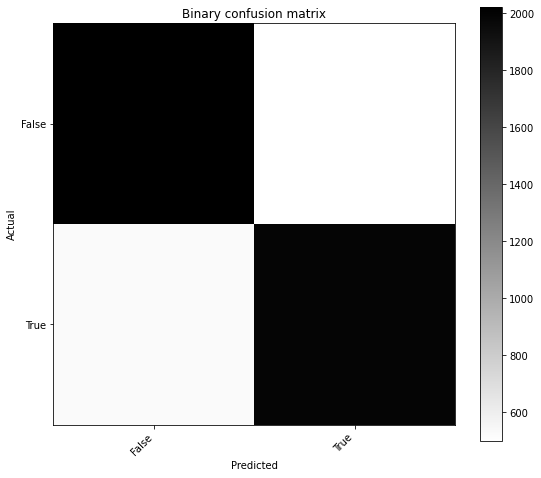

In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
testLocuteur(model, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_loc_entrainement1.csv", "drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [1.84930846e-04 9.99815047e-01]
 [2.07106568e-04 9.99792874e-01]
 [7.59558907e-06 9.99992371e-01]
 [1.89319544e-05 9.99981046e-01]
 [4.21772211e-06 9.99995828e-01]
 [2.20348607e-04 9.99779642e-01]
 [1.22813435e-05 9.99987721e-01]
 [3.05654248e-06 9.99996901e-01]
 [6.66931737e-05 9.99933243e-01]
 [4.18506315e-05 9.99958158e-01]
 [7.37451228e-06 9.99992609e-01]
 [9.53508334e-06 9.99990463e-01]
 [9.53768962e-04 9.99046266e-01]
 [1.35206237e-05 9.99986529e-01]
 [2.00715367e-05 9.99979973e-01]
 [8.40728717e-06 9.99991536e-01]
 [8.67080162e-05 9.99913335e-01]
 [1.71006741e-05 9.99982953e-01]
 [1.55894907e-06 9.99998450e-01]
 [9.97677982e-01 2.32200464e-03]
 [1.03921047e-03 9.98960733e-01]
 [1.00351230e-03 9.98996437e-01]
 [1.04581177e-05 9.99989510e-01]
 [4.55039024e-01 5.44960976e-01]
 [1.34554005e-03 9.98654485e-01]
 [9.97244239e-01 2.75581074e-03]
 [2.98871309e-05 9.99970078e-01]]
drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_

In [ ]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_seg_entrainement1.csv", "/content/drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*")

['E', 'a', 'I', 'A']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
proba = model.predict(x_test)
print(proba)

In [ ]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

In [ ]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["contexte_gauche"] = fileNames[i].split('_')[-4]
  score["contexte_droit"] = fileNames[i].split('_')[-3]
  score["contextes"] = fileNames[i].split('_')[-4] + "_" + fileNames[i].split('_')[-3]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_contexte_entrainement1.csv")

In [ ]:
print(resultats)

# Entraînement en retirant 5 locuteurs - 1


In [ ]:
locs_test = ['30_11_07_nb1_1_16', '30_11_07_nb1_2_16', '29_11_07_nb2_1_16', '29_11_07_nb2_2_16', '29_11_07_nb1_2_16']
for locuteur in locs_test:
  comp =0
  for path in glb.glob('/content/drive/Shareddrives/ReseauNeurones/images/train_aA_et_EI/*/*'):
    fileName = path.split('/')[-1]
    if locuteur in fileName:
      comp += 1
  print(comp)

print(comp)

204
204
204
204
204
204


In [37]:
path_input = 'drive/Shareddrives/ReseauNeurones/images/train/*'
path_test = 'drive/Shareddrives/ReseauNeurones/images/train_aA_et_EI/*/*'
path_locs = 'drive/Shareddrives/ReseauNeurones/images/train/*/*'
locs = getListLocuteur(path_locs)
locs_40 = locs[5:]
locs_5 = locs[:5]
print(locs_5)
print(locs_40)
x_train_locs_40, y_train_locs_40 = [], []
x_test_locs_5, y_test_locs_5 = [], []
fileNames = []
fileNames_test = []
minimum = 102

for locuteur in locs_40:
  for path in glb.glob(path_input):
    comp = 0
    for path_to_file in glb.glob(path+"/*"):
      if locuteur in path_to_file.split('/')[-1] and comp < minimum:
        label = path_to_file.split('/')[-2]
        x = cv2.imread(path_to_file, 0).astype(np.uint8)
        x = cv2.resize(x, (img_rows, img_cols))
        y = dicoLocs[label]
        x_train_locs_40.append(x)
        y_train_locs_40.append(y)
        fileNames.append(path_to_file.split('/')[-1])
        comp += 1

#print(len(x_test_loc))
x_train_locs_40 = np.array(x_train_locs_40)
x_train_locs_40 = x_train_locs_40.reshape(-1, x_train_locs_40.shape[1],x_train_locs_40.shape[2],1)
x_train_locs_40 = x_train_locs_40.astype('float32')
x_train_locs_40 /= 255. 

y_train_locs_40 = np.array(y_train_locs_40)
y_train_locs_40 = to_categorical(y_train_locs_40, num_classes, dtype='float32')

for locuteur in locs_5:
  for path in glb.glob(path_test):
    fileName = path.split('/')[-1]
    if locuteur in fileName:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_locs_5.append(x)
      y_test_locs_5.append(y)
      fileNames_test.append(fileName)

# #print(len(x_test_loc))
x_test_locs_5 = np.array(x_test_locs_5)
x_test_locs_5 = x_test_locs_5.reshape(-1, x_test_locs_5.shape[1],x_test_locs_5.shape[2],1)
x_test_locs_5 = x_test_locs_5.astype('float32')
x_test_locs_5 /= 255. 

y_test_locs_5 = np.array(y_test_locs_5)
y_test_locs_5 = to_categorical(y_test_locs_5, num_classes, dtype='float32')


print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))


['29_11_07_nb1_2_16', '29_11_07_nb2_1_16', '29_11_07_nb2_2_16', '30_11_07_nb1_1_16', '30_11_07_nb1_2_16']
['27_11_07_nb2_2_16', '28_11_07_nb1_1_16', '28_11_07_nb1_2_16', '28_11_07_nb2_1_16', '28_11_07_nb2_2_16', '26_11_07_nb3_2_16', '27_11_07_nb1_1_16', '27_11_07_nb1_2_16', '27_11_07_nb2_1_16', '26_11_07_nb1_1_16', '26_11_07_nb1_2_16', '26_11_07_nb2_1_16', '26_11_07_nb2_2_16', '26_11_07_nb3_1_16', '22_11_07_nb2_1_16', '22_11_07_nb2_2_16', '23_11_07_nb1_1_16', '23_11_07_nb1_2_16', '16_11_07_nb2_2_16', '20_11_07_nb1_1_16', '20_11_07_nb1_2_16', '22_11_07_nb1_1_16', '22_11_07_nb1_2_16', '14_11_07_nb2_2_16', '16_11_07_nb1_1_16', '16_11_07_nb1_2_16', '16_11_07_nb2_1_16', '05_12_07_nb1_1_16', '05_12_07_nb1_2_16', '14_11_07_nb1_1_16', '14_11_07_nb1_2_16', '14_11_07_nb2_1_16', '04_12_07_nb2_1_16', '04_12_07_nb2_2_16', '04_12_07_nb3_1_16', '04_12_07_nb3_2_16', '03_12_07_nb1_1_16', '03_12_07_nb1_2_16', '04_12_07_nb1_1_16', '04_12_07_nb1_2_16']
8160 8160 8160
1020 1020 1020


In [ ]:
print(x_train_locs_40)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

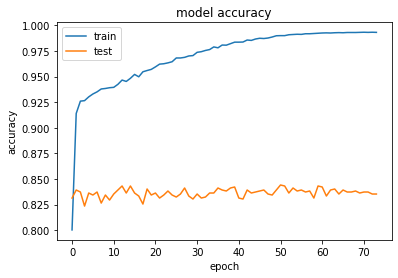

              precision    recall  f1-score   support

           0       0.79      0.90      0.85       510
           1       0.89      0.77      0.82       510

    accuracy                           0.84      1020
   macro avg       0.84      0.84      0.83      1020
weighted avg       0.84      0.84      0.83      1020



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [39]:
model = keras_RN(x_train_locs_40, y_train_locs_40, x_test_locs_5, y_test_locs_5, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [40]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_sans_5locs_model1')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_sans_5locs_model1/assets


(-0.5, 1.5, 1.5, -0.5)

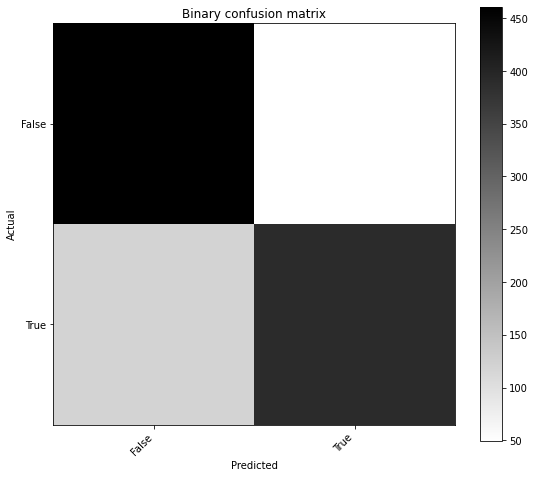

In [41]:
predictions = model.predict(np.array(x_test_locs_5), batch_size=100)
ConfusionMatrix(np.array(y_test_locs_5.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [42]:
print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))

8160 8160 8160
1020 1020 1020


# Entraînement en retirant 5 locuteurs - 2



In [43]:
path_input = 'drive/Shareddrives/ReseauNeurones/images/train/*'
path_test = 'drive/Shareddrives/ReseauNeurones/images/train_aA_et_EI/*/*'
path_locs = 'drive/Shareddrives/ReseauNeurones/images/train/*/*'
locs = getListLocuteur(path_locs)
locs_40 = locs[10:] + locs[:5]
locs_5 = locs[5:10]
print(locs_5)
print(locs_40)
x_train_locs_40, y_train_locs_40 = [], []
x_test_locs_5, y_test_locs_5 = [], []
fileNames = []
fileNames_test = []
minimum = 102

for locuteur in locs_40:
  for path in glb.glob(path_input):
    comp = 0
    for path_to_file in glb.glob(path+"/*"):
      if locuteur in path_to_file.split('/')[-1] and comp < minimum:
        label = path_to_file.split('/')[-2]
        x = cv2.imread(path_to_file, 0).astype(np.uint8)
        x = cv2.resize(x, (img_rows, img_cols))
        y = dicoLocs[label]
        x_train_locs_40.append(x)
        y_train_locs_40.append(y)
        fileNames.append(path_to_file.split('/')[-1])
        comp += 1

#print(len(x_test_loc))
x_train_locs_40 = np.array(x_train_locs_40)
x_train_locs_40 = x_train_locs_40.reshape(-1, x_train_locs_40.shape[1],x_train_locs_40.shape[2],1)
x_train_locs_40 = x_train_locs_40.astype('float32')
x_train_locs_40 /= 255. 

y_train_locs_40 = np.array(y_train_locs_40)
y_train_locs_40 = to_categorical(y_train_locs_40, num_classes, dtype='float32')

for locuteur in locs_5:
  for path in glb.glob(path_test):
    fileName = path.split('/')[-1]
    if locuteur in fileName:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_locs_5.append(x)
      y_test_locs_5.append(y)
      fileNames_test.append(fileName)

# #print(len(x_test_loc))
x_test_locs_5 = np.array(x_test_locs_5)
x_test_locs_5 = x_test_locs_5.reshape(-1, x_test_locs_5.shape[1],x_test_locs_5.shape[2],1)
x_test_locs_5 = x_test_locs_5.astype('float32')
x_test_locs_5 /= 255. 

y_test_locs_5 = np.array(y_test_locs_5)
y_test_locs_5 = to_categorical(y_test_locs_5, num_classes, dtype='float32')


print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))


['27_11_07_nb2_2_16', '28_11_07_nb1_1_16', '28_11_07_nb1_2_16', '28_11_07_nb2_1_16', '28_11_07_nb2_2_16']
['26_11_07_nb3_2_16', '27_11_07_nb1_1_16', '27_11_07_nb1_2_16', '27_11_07_nb2_1_16', '26_11_07_nb1_1_16', '26_11_07_nb1_2_16', '26_11_07_nb2_1_16', '26_11_07_nb2_2_16', '26_11_07_nb3_1_16', '22_11_07_nb2_1_16', '22_11_07_nb2_2_16', '23_11_07_nb1_1_16', '23_11_07_nb1_2_16', '16_11_07_nb2_2_16', '20_11_07_nb1_1_16', '20_11_07_nb1_2_16', '22_11_07_nb1_1_16', '22_11_07_nb1_2_16', '14_11_07_nb2_2_16', '16_11_07_nb1_1_16', '16_11_07_nb1_2_16', '16_11_07_nb2_1_16', '05_12_07_nb1_1_16', '05_12_07_nb1_2_16', '14_11_07_nb1_1_16', '14_11_07_nb1_2_16', '14_11_07_nb2_1_16', '04_12_07_nb2_1_16', '04_12_07_nb2_2_16', '04_12_07_nb3_1_16', '04_12_07_nb3_2_16', '03_12_07_nb1_1_16', '03_12_07_nb1_2_16', '04_12_07_nb1_1_16', '04_12_07_nb1_2_16', '29_11_07_nb1_2_16', '29_11_07_nb2_1_16', '29_11_07_nb2_2_16', '30_11_07_nb1_1_16', '30_11_07_nb1_2_16']
8160 8160 8160
1020 1020 1020


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

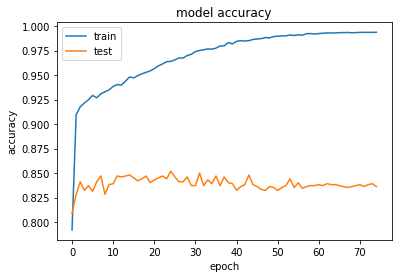

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.78      0.95      0.85       510
           1       0.93      0.73      0.82       510

    accuracy                           0.84      1020
   macro avg       0.85      0.84      0.83      1020
weighted avg       0.85      0.84      0.83      1020



In [44]:
model = keras_RN(x_train_locs_40, y_train_locs_40, x_test_locs_5, y_test_locs_5, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [45]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_sans_5locs_model1-2')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_sans_5locs_model1-2/assets


(-0.5, 1.5, 1.5, -0.5)

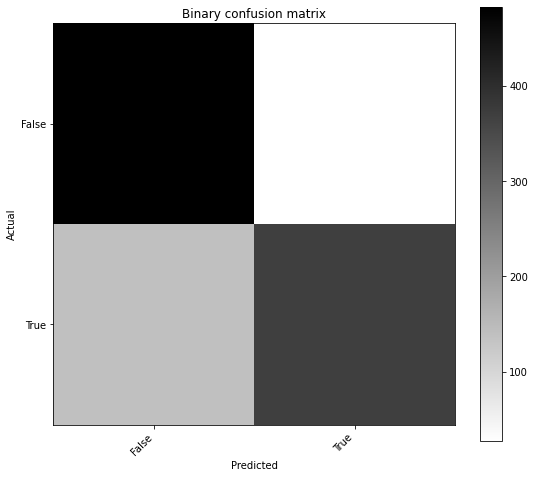

In [46]:
predictions = model.predict(np.array(x_test_locs_5), batch_size=100)
ConfusionMatrix(np.array(y_test_locs_5.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [47]:
print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))

8160 8160 8160
1020 1020 1020


# Entraînement en retirant 5 locuteurs - 3



In [48]:
path_input = 'drive/Shareddrives/ReseauNeurones/images/train/*'
path_test = 'drive/Shareddrives/ReseauNeurones/images/train_aA_et_EI/*/*'
path_locs = 'drive/Shareddrives/ReseauNeurones/images/train/*/*'
locs = getListLocuteur(path_locs)
locs_40 = locs[20:] + locs[:15]
locs_5 = locs[15:20]
print(locs_5)
print(locs_40)
x_train_locs_40, y_train_locs_40 = [], []
x_test_locs_5, y_test_locs_5 = [], []
fileNames = []
fileNames_test = []
minimum = 102

for locuteur in locs_40:
  for path in glb.glob(path_input):
    comp = 0
    for path_to_file in glb.glob(path+"/*"):
      if locuteur in path_to_file.split('/')[-1] and comp < minimum:
        label = path_to_file.split('/')[-2]
        x = cv2.imread(path_to_file, 0).astype(np.uint8)
        x = cv2.resize(x, (img_rows, img_cols))
        y = dicoLocs[label]
        x_train_locs_40.append(x)
        y_train_locs_40.append(y)
        fileNames.append(path_to_file.split('/')[-1])
        comp += 1

#print(len(x_test_loc))
x_train_locs_40 = np.array(x_train_locs_40)
x_train_locs_40 = x_train_locs_40.reshape(-1, x_train_locs_40.shape[1],x_train_locs_40.shape[2],1)
x_train_locs_40 = x_train_locs_40.astype('float32')
x_train_locs_40 /= 255. 

y_train_locs_40 = np.array(y_train_locs_40)
y_train_locs_40 = to_categorical(y_train_locs_40, num_classes, dtype='float32')

for locuteur in locs_5:
  for path in glb.glob(path_test):
    fileName = path.split('/')[-1]
    if locuteur in fileName:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_locs_5.append(x)
      y_test_locs_5.append(y)
      fileNames_test.append(fileName)

# #print(len(x_test_loc))
x_test_locs_5 = np.array(x_test_locs_5)
x_test_locs_5 = x_test_locs_5.reshape(-1, x_test_locs_5.shape[1],x_test_locs_5.shape[2],1)
x_test_locs_5 = x_test_locs_5.astype('float32')
x_test_locs_5 /= 255. 

y_test_locs_5 = np.array(y_test_locs_5)
y_test_locs_5 = to_categorical(y_test_locs_5, num_classes, dtype='float32')


print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))


['26_11_07_nb1_2_16', '26_11_07_nb2_1_16', '26_11_07_nb2_2_16', '26_11_07_nb3_1_16', '22_11_07_nb2_1_16']
['22_11_07_nb2_2_16', '23_11_07_nb1_1_16', '23_11_07_nb1_2_16', '16_11_07_nb2_2_16', '20_11_07_nb1_1_16', '20_11_07_nb1_2_16', '22_11_07_nb1_1_16', '22_11_07_nb1_2_16', '14_11_07_nb2_2_16', '16_11_07_nb1_1_16', '16_11_07_nb1_2_16', '16_11_07_nb2_1_16', '05_12_07_nb1_1_16', '05_12_07_nb1_2_16', '14_11_07_nb1_1_16', '14_11_07_nb1_2_16', '14_11_07_nb2_1_16', '04_12_07_nb2_1_16', '04_12_07_nb2_2_16', '04_12_07_nb3_1_16', '04_12_07_nb3_2_16', '03_12_07_nb1_1_16', '03_12_07_nb1_2_16', '04_12_07_nb1_1_16', '04_12_07_nb1_2_16', '29_11_07_nb1_2_16', '29_11_07_nb2_1_16', '29_11_07_nb2_2_16', '30_11_07_nb1_1_16', '30_11_07_nb1_2_16', '27_11_07_nb2_2_16', '28_11_07_nb1_1_16', '28_11_07_nb1_2_16', '28_11_07_nb2_1_16', '28_11_07_nb2_2_16', '26_11_07_nb3_2_16', '27_11_07_nb1_1_16', '27_11_07_nb1_2_16', '27_11_07_nb2_1_16', '26_11_07_nb1_1_16']
8160 8160 8160
1020 1020 1020


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

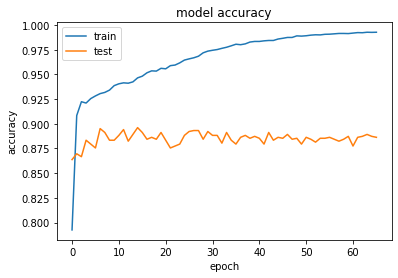

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       510
           1       0.94      0.82      0.88       510

    accuracy                           0.89      1020
   macro avg       0.89      0.89      0.89      1020
weighted avg       0.89      0.89      0.89      1020



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [49]:
model = keras_RN(x_train_locs_40, y_train_locs_40, x_test_locs_5, y_test_locs_5, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [50]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_sans_5locs_model1-3')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_sans_5locs_model1-3/assets


(-0.5, 1.5, 1.5, -0.5)

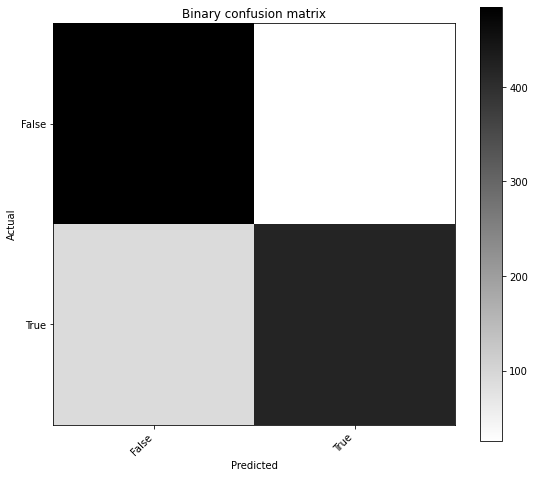

In [51]:
predictions = model.predict(np.array(x_test_locs_5), batch_size=100)
ConfusionMatrix(np.array(y_test_locs_5.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [52]:
print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))

8160 8160 8160
1020 1020 1020


# Entraînement en retirant 5 locuteurs - 4



In [53]:
path_input = 'drive/Shareddrives/ReseauNeurones/images/train/*'
path_test = 'drive/Shareddrives/ReseauNeurones/images/train_aA_et_EI/*/*'
path_locs = 'drive/Shareddrives/ReseauNeurones/images/train/*/*'
locs = getListLocuteur(path_locs)
locs_40 = locs[:40]
locs_5 = locs[40:]
print(locs_5)
print(locs_40)
x_train_locs_40, y_train_locs_40 = [], []
x_test_locs_5, y_test_locs_5 = [], []
fileNames = []
fileNames_test = []
minimum = 102

for locuteur in locs_40:
  for path in glb.glob(path_input):
    comp = 0
    for path_to_file in glb.glob(path+"/*"):
      if locuteur in path_to_file.split('/')[-1] and comp < minimum:
        label = path_to_file.split('/')[-2]
        x = cv2.imread(path_to_file, 0).astype(np.uint8)
        x = cv2.resize(x, (img_rows, img_cols))
        y = dicoLocs[label]
        x_train_locs_40.append(x)
        y_train_locs_40.append(y)
        fileNames.append(path_to_file.split('/')[-1])
        comp += 1

#print(len(x_test_loc))
x_train_locs_40 = np.array(x_train_locs_40)
x_train_locs_40 = x_train_locs_40.reshape(-1, x_train_locs_40.shape[1],x_train_locs_40.shape[2],1)
x_train_locs_40 = x_train_locs_40.astype('float32')
x_train_locs_40 /= 255. 

y_train_locs_40 = np.array(y_train_locs_40)
y_train_locs_40 = to_categorical(y_train_locs_40, num_classes, dtype='float32')

for locuteur in locs_5:
  for path in glb.glob(path_test):
    fileName = path.split('/')[-1]
    if locuteur in fileName:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_locs_5.append(x)
      y_test_locs_5.append(y)
      fileNames_test.append(fileName)

# #print(len(x_test_loc))
x_test_locs_5 = np.array(x_test_locs_5)
x_test_locs_5 = x_test_locs_5.reshape(-1, x_test_locs_5.shape[1],x_test_locs_5.shape[2],1)
x_test_locs_5 = x_test_locs_5.astype('float32')
x_test_locs_5 /= 255. 

y_test_locs_5 = np.array(y_test_locs_5)
y_test_locs_5 = to_categorical(y_test_locs_5, num_classes, dtype='float32')


print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))


['04_12_07_nb3_2_16', '03_12_07_nb1_1_16', '03_12_07_nb1_2_16', '04_12_07_nb1_1_16', '04_12_07_nb1_2_16']
['29_11_07_nb1_2_16', '29_11_07_nb2_1_16', '29_11_07_nb2_2_16', '30_11_07_nb1_1_16', '30_11_07_nb1_2_16', '27_11_07_nb2_2_16', '28_11_07_nb1_1_16', '28_11_07_nb1_2_16', '28_11_07_nb2_1_16', '28_11_07_nb2_2_16', '26_11_07_nb3_2_16', '27_11_07_nb1_1_16', '27_11_07_nb1_2_16', '27_11_07_nb2_1_16', '26_11_07_nb1_1_16', '26_11_07_nb1_2_16', '26_11_07_nb2_1_16', '26_11_07_nb2_2_16', '26_11_07_nb3_1_16', '22_11_07_nb2_1_16', '22_11_07_nb2_2_16', '23_11_07_nb1_1_16', '23_11_07_nb1_2_16', '16_11_07_nb2_2_16', '20_11_07_nb1_1_16', '20_11_07_nb1_2_16', '22_11_07_nb1_1_16', '22_11_07_nb1_2_16', '14_11_07_nb2_2_16', '16_11_07_nb1_1_16', '16_11_07_nb1_2_16', '16_11_07_nb2_1_16', '05_12_07_nb1_1_16', '05_12_07_nb1_2_16', '14_11_07_nb1_1_16', '14_11_07_nb1_2_16', '14_11_07_nb2_1_16', '04_12_07_nb2_1_16', '04_12_07_nb2_2_16', '04_12_07_nb3_1_16']
8160 8160 8160
1020 1020 1020


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

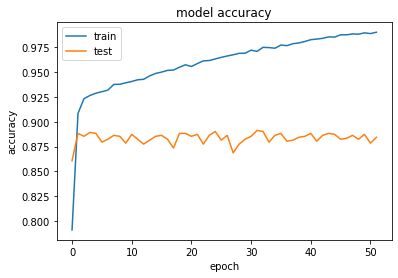

              precision    recall  f1-score   support

           0       0.84      0.96      0.89       510
           1       0.95      0.81      0.88       510

    accuracy                           0.88      1020
   macro avg       0.89      0.88      0.88      1020
weighted avg       0.89      0.88      0.88      1020



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [54]:
model = keras_RN(x_train_locs_40, y_train_locs_40, x_test_locs_5, y_test_locs_5, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [55]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_sans_5locs_model1-4')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_sans_5locs_model1-4/assets


(-0.5, 1.5, 1.5, -0.5)

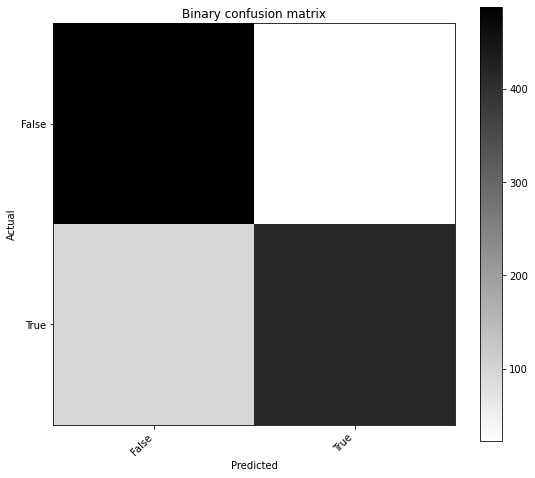

In [56]:
predictions = model.predict(np.array(x_test_locs_5), batch_size=100)
ConfusionMatrix(np.array(y_test_locs_5.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [57]:
print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))

8160 8160 8160
1020 1020 1020


In [ ]:
print(x_test_locs_5)
print(y_test_locs_5)

##Entraînement 2
    activation : relu
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="relu", loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta())

In [ ]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_model2')

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_model2')

In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
testLocuteur(model, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_loc_entrainement2.csv", "drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*")

In [ ]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_seg_entrainement2.csv", "/content/drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*")

['E', 'a', 'I', 'A']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
proba = model.predict_proba(x_test)
print(proba)

In [ ]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

In [ ]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["contexte_gauche"] = fileNames[i].split('_')[-4]
  score["contexte_droit"] = fileNames[i].split('_')[-3]
  score["contextes"] = fileNames[i].split('_')[-4] + "_" + fileNames[i].split('_')[-3]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_contexte_entrainement2.csv")


##Entraînement 3
    activation : tanh
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])




In [ ]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="tanh", loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta())

In [ ]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_model3')

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_model3')

In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
testLocuteur(model, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_loc_entrainement3.csv", "drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*")

In [ ]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_seg_entrainement3.csv", "/content/drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*")

['E', 'a', 'I', 'A']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
proba = model.predict_proba(x_test)
print(proba)

In [ ]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

In [ ]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["contexte_gauche"] = fileNames[i].split('_')[-4]
  score["contexte_droit"] = fileNames[i].split('_')[-3]
  score["contextes"] = fileNames[i].split('_')[-4] + "_" + fileNames[i].split('_')[-3]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_contexte_entrainement3.csv")

##Entraînement 4
    activation : relu
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])


In [ ]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="relu", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [ ]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_model4')

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/train_aA_test_aAEI_model4')

In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
testLocuteur(model, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_loc_entrainement4.csv", "drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*")

In [ ]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_seg_entrainement4.csv", "/content/drive/Shareddrives/ReseauNeurones/images/test_aAEI/*/*")

['E', 'a', 'I', 'A']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
proba = model.predict_proba(x_test)
print(proba)

In [ ]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

In [ ]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["contexte_gauche"] = fileNames[i].split('_')[-4]
  score["contexte_droit"] = fileNames[i].split('_')[-3]
  score["contextes"] = fileNames[i].split('_')[-4] + "_" + fileNames[i].split('_')[-3]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aA_test_aAEI/all_score_contexte_entrainement4.csv")



---

---





Et quelques autres entraînements pour essayer de voir d'où vient la différence au niveau de la progression dans un entraînement...


---

---





In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[es,mc])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

best_model=keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
val_loss_list=history.history['val_loss']
best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
val_acc_list = history.history["val_accuracy"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

print("loss on test set : ", test_loss)
print("accuracy on test set : ", test_acc)
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)


In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[es,mc])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

best_model=keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
val_loss_list=history.history['val_loss']
best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
val_acc_list = history.history["val_accuracy"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

print("loss on test set : ", test_loss)
print("accuracy on test set : ", test_acc)
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)


In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()